So ini list apa yang aku nak kau buat tau. I want u to

1) compare area kalau guna 2 clusters and 3 clusters

2) apply bwareaopen ( to remove small objects from binary image)

3) apply imclearborder ( to clear other than ROI that’s on the border)

4) apply hole filling ( to fill ROI tu kalau ada lubang)

5) explain breifly maksud coding tu line by line ( pendek je, janji paham)

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
%matplotlib inline
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from mpl_toolkits.mplot3d import Axes3D
from time import time
import scipy.fftpack # For FFT2 

In [15]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    # return the histogram
    return hist

def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

def change_color_kmeans(predict_img, clusters):
    img = []
    for val in predict_img:
        img.append(clusters[val])
    return img

def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

def readimage():
    folder = 'image-cancer/'
    list_images = os.listdir(folder)
    list_img = []
    for i in list_images:
        path = folder+i
        print(path)
        img = cv2.imread(path)
        rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))
        list_img.append(rgb_img)
        
    return list_img

def bwarea(img):
    row = img.shape[0]
    col = img.shape[1]
    total = 0.0
    for r in range(row-1):
        for c in range(col-1):
            sub_total = img[r:r+2, c:c+2].mean()
            if sub_total == 255:
                total += 1
            elif sub_total == (255.0/3.0):
                total += (7.0/8.0)
            elif sub_total == (255.0/4.0):
                total += 0.25
            elif sub_total == 0:
                total += 0
            else:
                r1c1 = img[r,c]
                r1c2 = img[r,c+1]
                r2c1 = img[r+1,c]
                r2c2 = img[r+1,c+1]
                
                if (((r1c1 == r2c2) & (r1c2 == r2c1)) & (r1c1 != r2c1)):
                    total += 0.75
                else:
                    total += 0.5
    return total
            
def imclearborder(imgBW, radius):

    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    image, contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy      

def imfill(im_th):
    
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_out

In [19]:
list_img = readimage()

n_data = len(list_img)

image-cancer/1.png
image-cancer/12.png
image-cancer/13.png
image-cancer/14.png
image-cancer/15.png
image-cancer/17.png
image-cancer/18.png
image-cancer/2.png
image-cancer/31.png
image-cancer/32.png
image-cancer/34.png
image-cancer/35.png
image-cancer/44.png
image-cancer/48.png
image-cancer/5.png
image-cancer/51.png
image-cancer/52.png
image-cancer/53.png
image-cancer/54.png
image-cancer/55.png
image-cancer/56.png
image-cancer/61.png
image-cancer/8.png


Image 1
Fuzzy time for cluster 2
0.24465346336364746 seconds
Bwarea : 861.0

Fuzzy time for cluster 3
0.42112088203430176 seconds
Bwarea : 750.25

Fuzzy time for cluster 6
2.145704746246338 seconds
Bwarea : 331.0

Fuzzy time for cluster 8
4.373628377914429 seconds
Bwarea : 293.5


Image 2
Fuzzy time for cluster 2
0.13535332679748535 seconds
Bwarea : 6723.0

Fuzzy time for cluster 3
0.6787793636322021 seconds
Bwarea : 6226.75

Fuzzy time for cluster 6
2.3743104934692383 seconds
Bwarea : 3982.75

Fuzzy time for cluster 8
3.806093692779541 seconds
Bwarea : 3550.75


Image 3
Fuzzy time for cluster 2
0.13435745239257812 seconds
Bwarea : 10217.25

Fuzzy time for cluster 3
0.4150989055633545 seconds
Bwarea : 9816.0

Fuzzy time for cluster 6
1.8940393924713135 seconds
Bwarea : 7220.0

Fuzzy time for cluster 8
4.452840089797974 seconds
Bwarea : 6544.25


Image 4
Fuzzy time for cluster 2
0.13736581802368164 seconds
Bwarea : 18853.5

Fuzzy time for cluster 3
0.35996127128601074 seconds
Bwarea : 1

C:\Users\Ariff\AppData\Local\conda\conda\envs\image_processing\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Bwarea : 13648.0

Fuzzy time for cluster 3
0.6297080516815186 seconds
Bwarea : 11078.75

Fuzzy time for cluster 6
1.5451414585113525 seconds
Bwarea : 7571.75

Fuzzy time for cluster 8
2.333203077316284 seconds
Bwarea : 5377.75


Image 22
Fuzzy time for cluster 2
0.1774747371673584 seconds
Bwarea : 1078.5

Fuzzy time for cluster 3
0.43813633918762207 seconds
Bwarea : 968.75

Fuzzy time for cluster 6
1.691528081893921 seconds
Bwarea : 156.75

Fuzzy time for cluster 8
5.086552381515503 seconds
Bwarea : 123.0


Image 23
Fuzzy time for cluster 2
0.1383349895477295 seconds
Bwarea : 10495.25

Fuzzy time for cluster 3
0.24164557456970215 seconds
Bwarea : 9839.75

Fuzzy time for cluster 6
2.3792998790740967 seconds
Bwarea : 7429.75

Fuzzy time for cluster 8
3.095238447189331 seconds
Bwarea : 6389.0




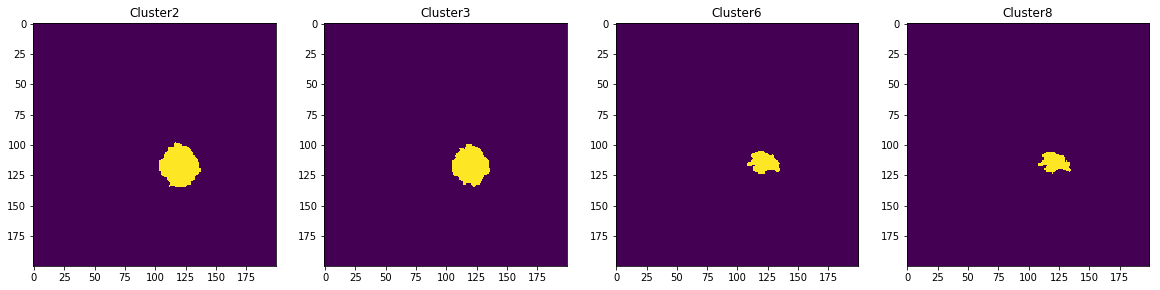

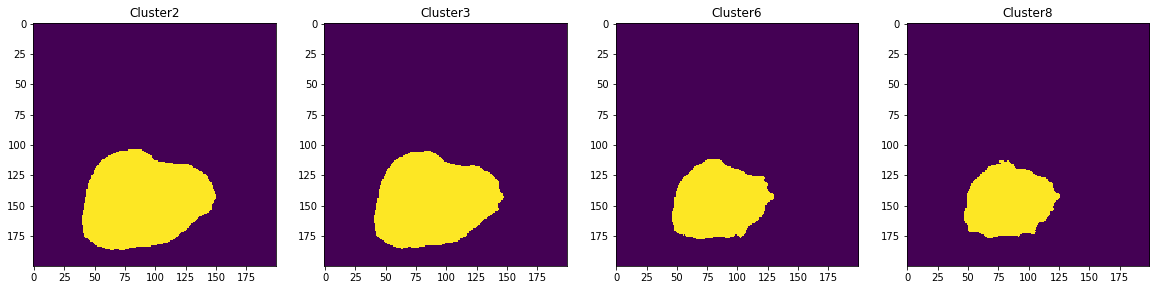

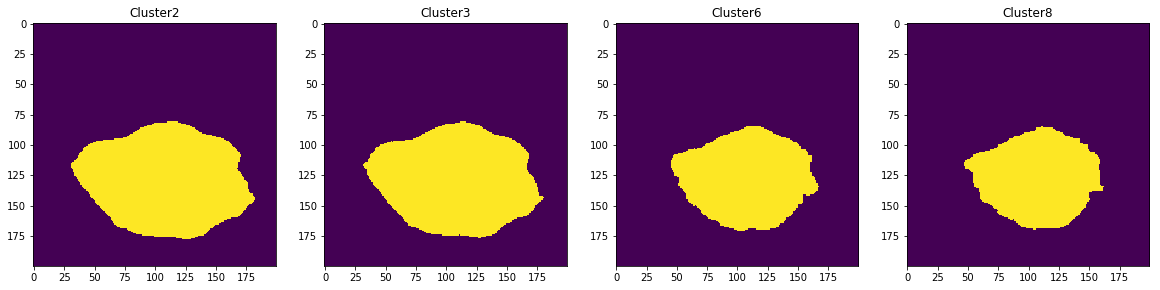

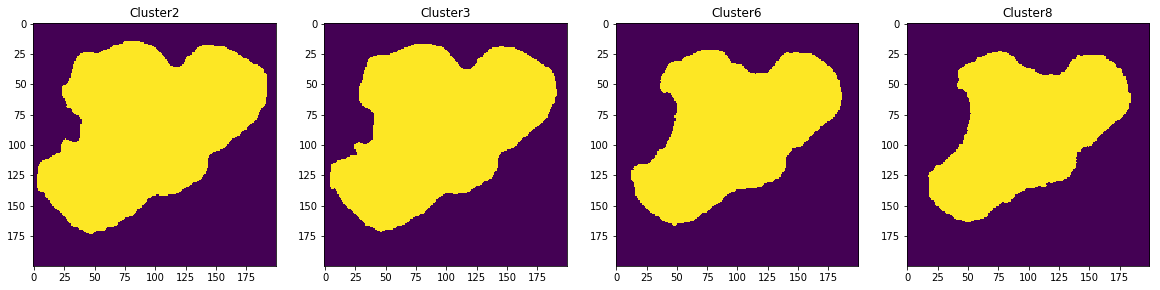

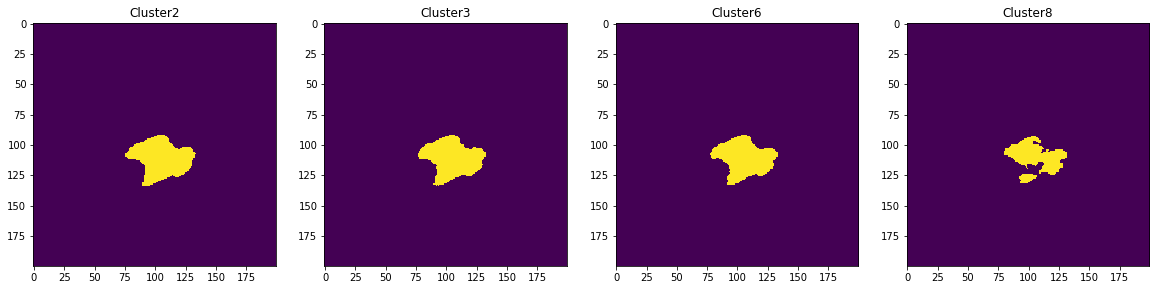

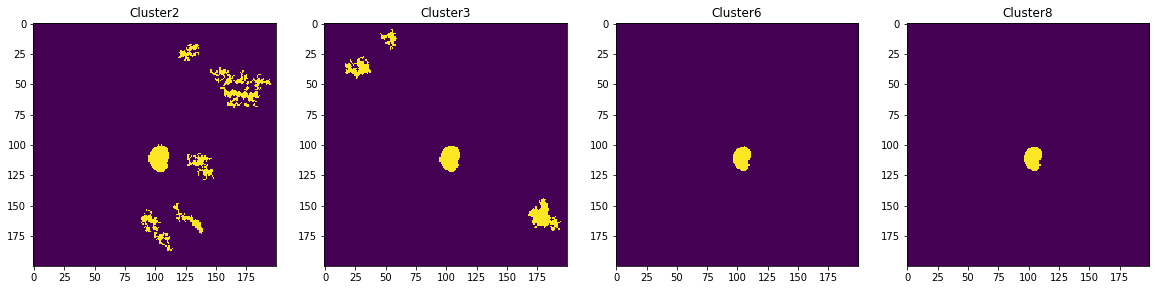

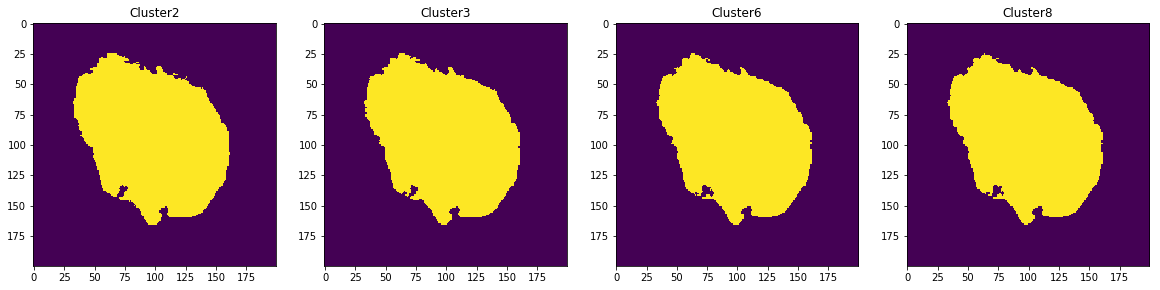

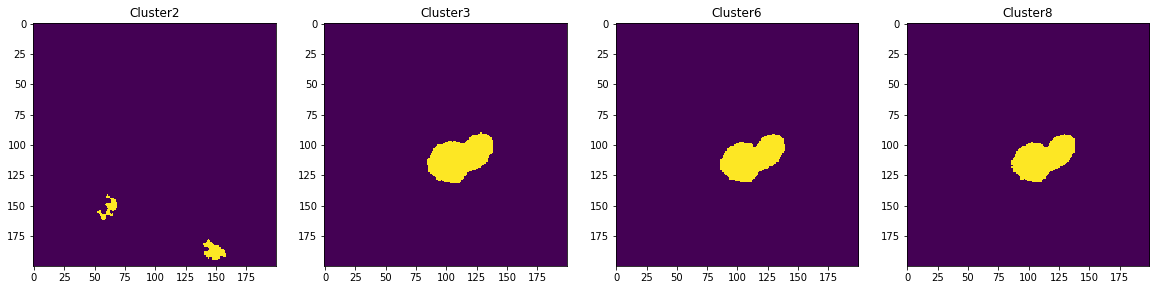

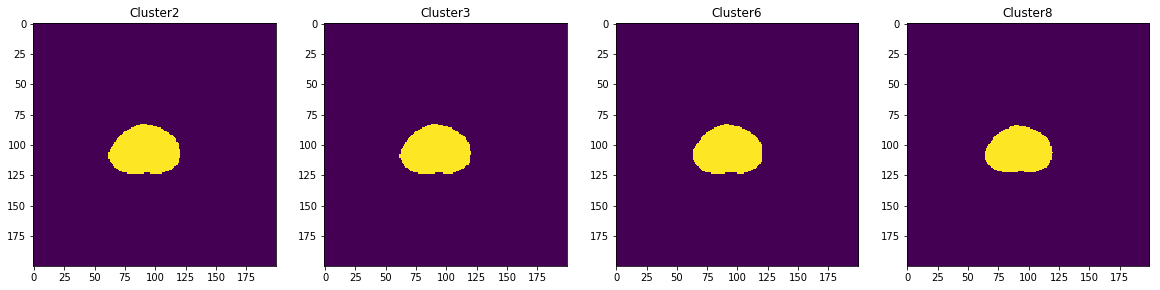

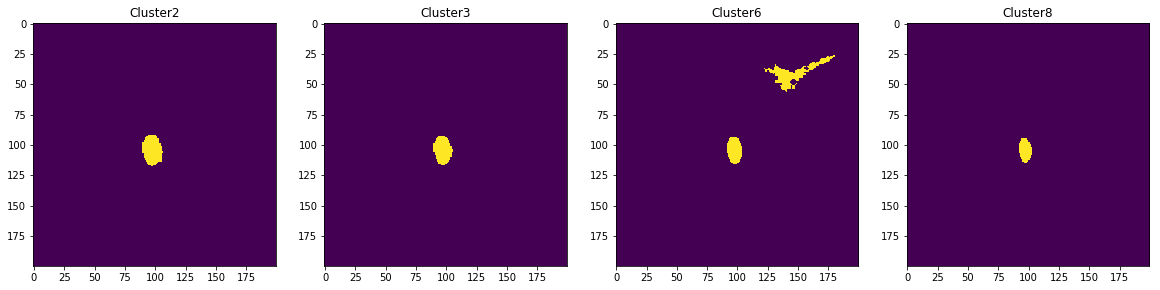

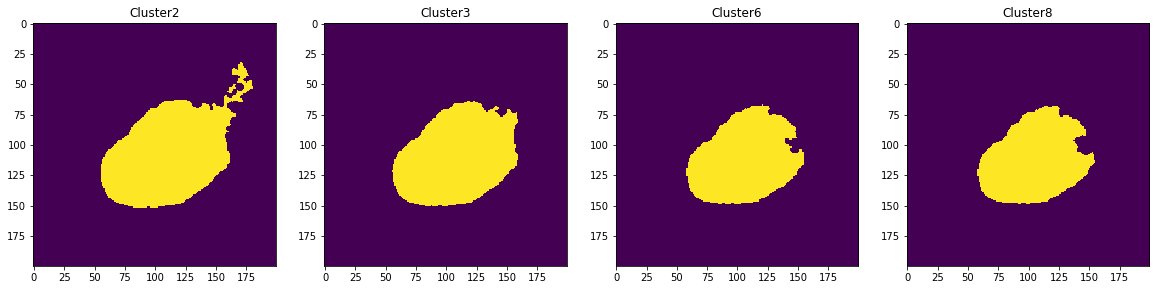

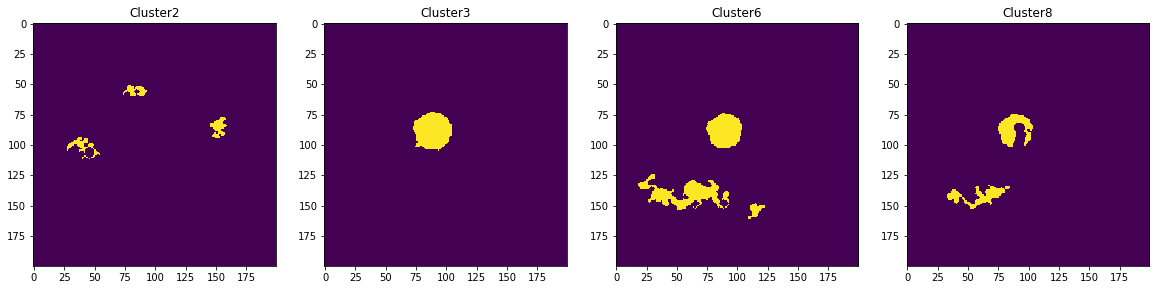

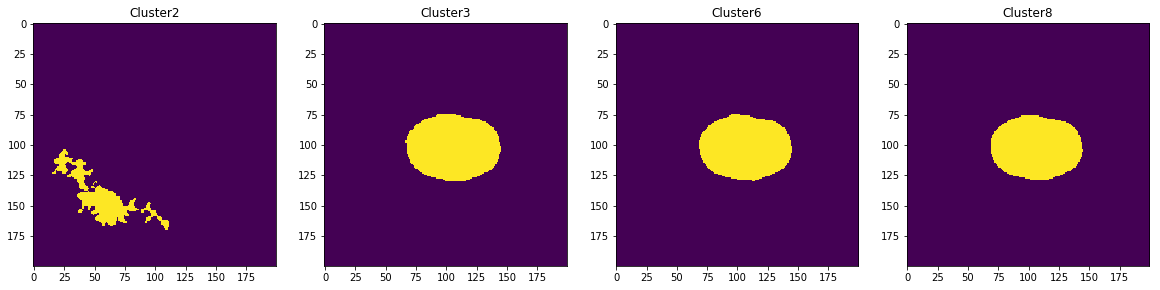

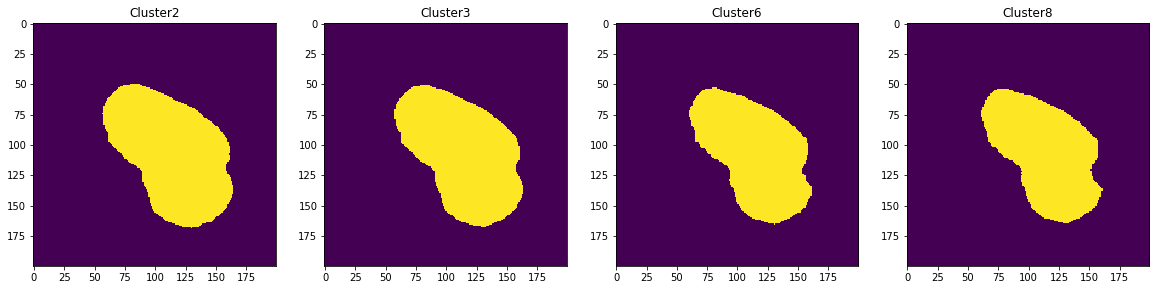

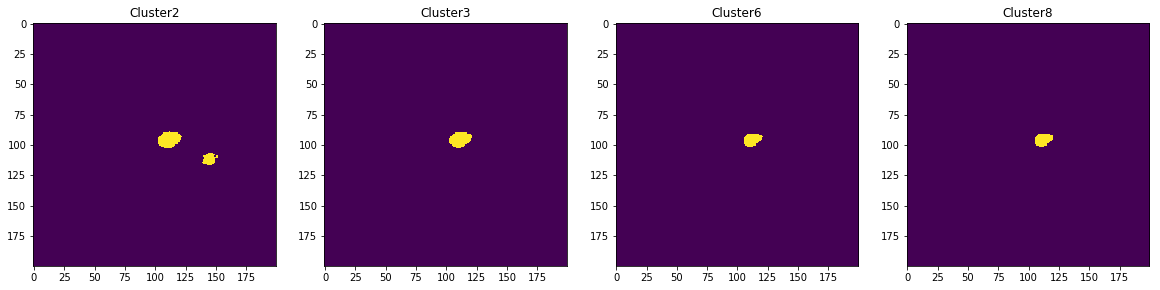

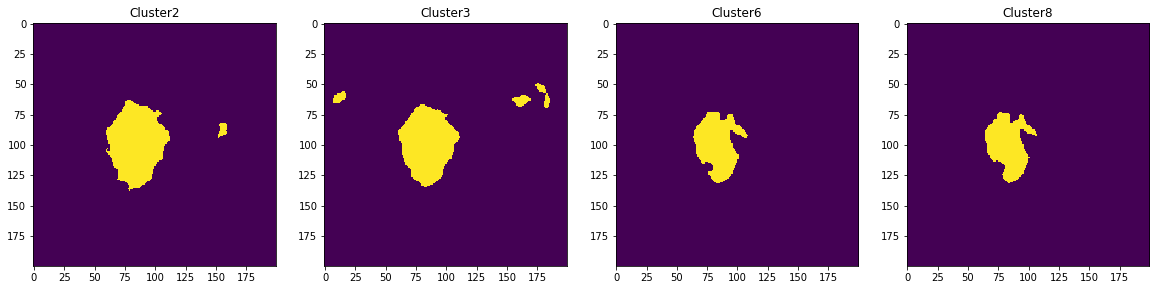

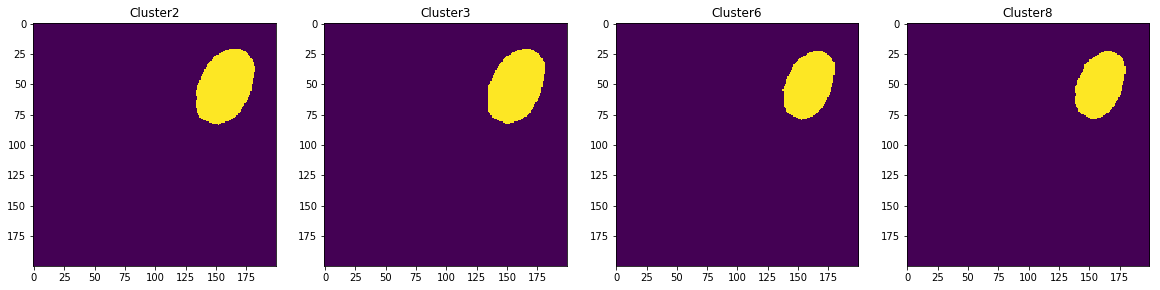

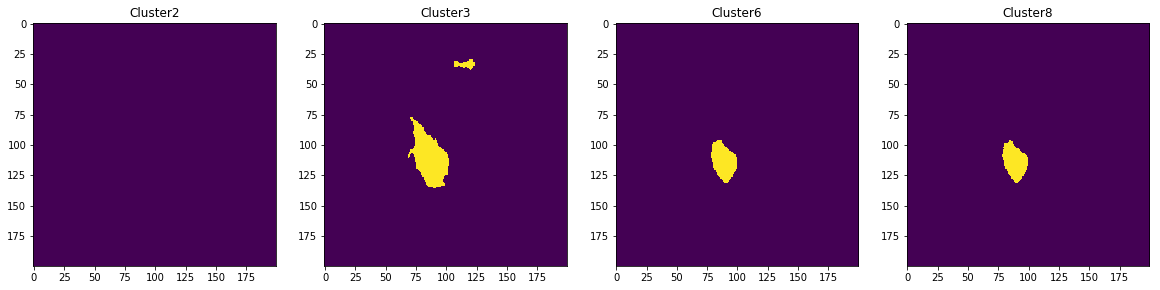

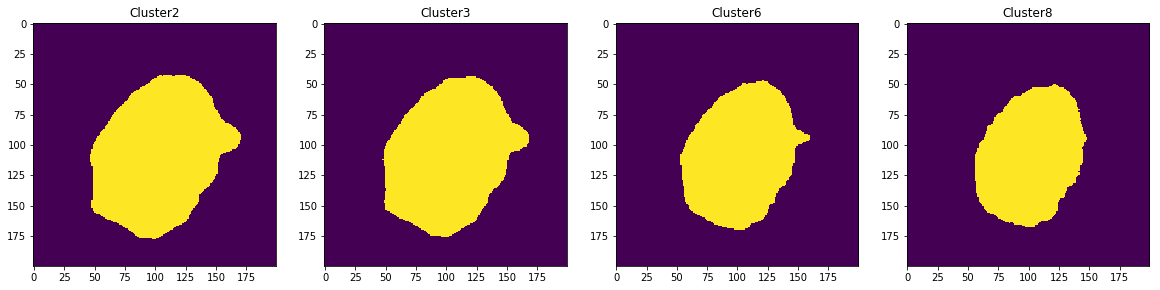

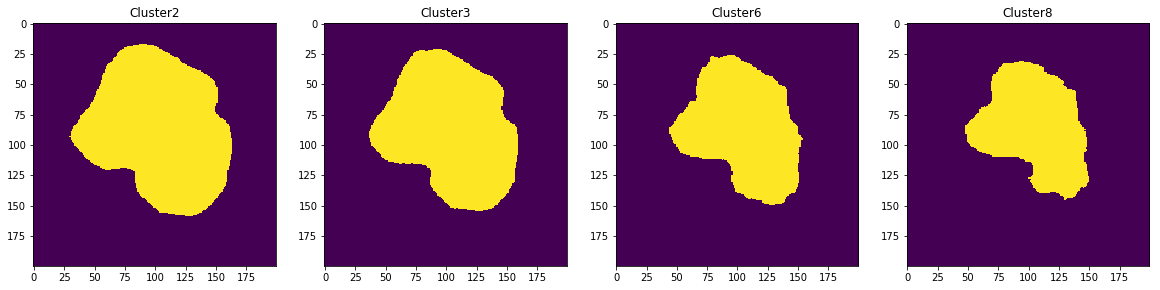

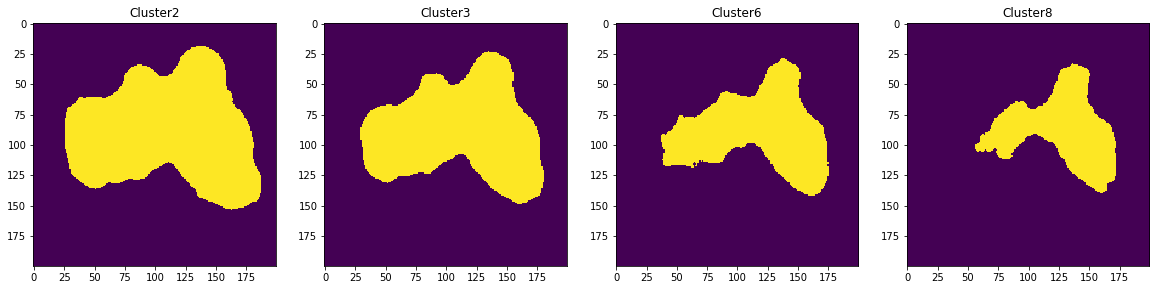

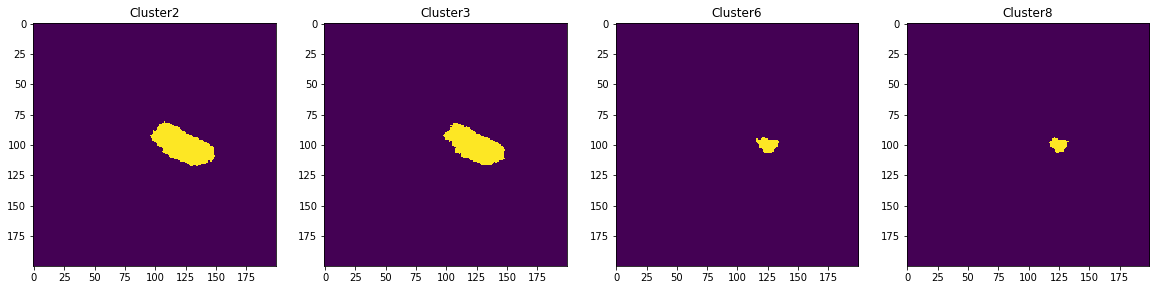

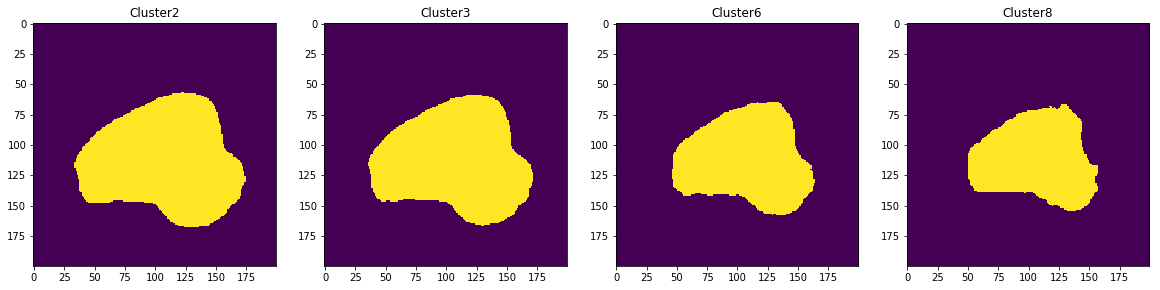

In [27]:
clusters = [2,3,6,8]
for index,rgb_img in enumerate(list_img):
    
    # initialize graph
    plt.figure(figsize=(20,20))
    print('Image '+str(index+1))
    for i,cluster in enumerate(clusters):
        img = np.reshape(rgb_img, (200,200,3)).astype(np.uint8)
        shape = np.shape(img)

        
        # Fuzzy C Means
        new_time = time()

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        rgb_img.T, cluster, 2, error=0.005, maxiter=1000, init=None,seed=42)

        new_img = change_color_fuzzycmeans(u,cntr)
        fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)
        ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)
        print('Fuzzy time for cluster',cluster)
        print(time() - new_time,'seconds')
        Iopen = bwareaopen(seg_img[:,:,1], 50)

        # Clear off the border.  Choose a border radius of 5 pixels
        Iclear = imclearborder(Iopen, 2)

        Iopen = bwareaopen(Iclear, 50)
        Iclear = imclearborder(Iopen, 2)
        Imfill = imfill(Iclear)
        
        print('Bwarea : '+str(bwarea(Imfill)))

        # show our color bart


        plt.subplot(1,4,i+1)
        plt.imshow(Imfill)
        name = 'Cluster'+str(cluster)
        plt.title(name)
        print()

    name = 'segmented'+str(index)+'.png'
    plt.savefig(name)
    print()
    